In [ ]:
import sys
!{sys.executable} -m pip install simpy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install names

In [1]:
# System modules# Syste 
import sys
from datetime import datetime
from IPython.display import display
from ipywidgets import Dropdown


# Data analysis modules
import pandas as pd
import numpy as np
from scipy import stats  
from scipy.stats import uniform, norm, beta, weibull_min, rv_discrete, gamma
import random

# SimPy modules
import simpy
from simpy import Resource, Container, FilterStore
from simpy.util import start_delayed

# Viz modules
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import branca.colormap as cm
from folium.plugins import MarkerCluster
from folium import Map, FeatureGroup, Marker, LayerControl

# DESaster Modules
desaster_path = "./DESaster-master" # <-- Change this for your path
sys.path.append(desaster_path)
import desaster
from desaster.io import *
from desaster.structures import *
from desaster.financial import *
from desaster.technical import *
from desaster.entities import *
from desaster.policies import *
from desaster.visualize import dashboard, folium_map

In [2]:
%matplotlib inline

In [3]:
# cincinnati = pd.read_csv('./DESaster-master/inputs/input_data_cincinnati.csv')
# sandiego = pd.read_csv('./DESaster-master/inputs/input_data_sandiego.csv')
# washingtondc = pd.read_csv('./DESaster-master/inputs/input_data_washingtondc.csv')


seattle = pd.read_csv('./DESaster-master/inputs/input_data_seattle.csv')
austin = pd.read_csv('./DESaster-master/inputs/input_data_austin.csv')
#louisville = pd.read_csv('./DESaster-master/inputs/input_data_louisville.csv')
nashville = pd.read_csv('./DESaster-master/inputs/input_data_nashville.csv')

/Users/rongdilin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (25,29,30,31,32,33,34,35,36,38,54,58,59,60,61,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/rongdilin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#filter seattle
seattle_clean = seattle[(seattle['Permit Type'] == 'Construction') & (seattle['Category'] == 'SINGLE FAMILY / DUPLEX')]

In [5]:
#filter austin
austin_clean = austin[(austin['PermitTypeDesc'] == 'Building Permit') & (austin['PermitClass'] == 'C- 101 Single Family Houses')]

In [6]:
#filter nashville
nashville_clean = nashville[(nashville['Permit Type Description'] == 'Building Residential - New') & (nashville['Permit Subtype Description'] == 'Single Family Residence')]

In [7]:
duration_seattle = (pd.to_datetime(seattle_clean['Issue Date']) - pd.to_datetime(seattle_clean['Application Date'])).dropna()
duration_austin = (pd.to_datetime(austin_clean['IssuedDate']) - pd.to_datetime(austin_clean['AppliedDate'])).dropna()
duration_nashville = (pd.to_datetime(nashville_clean['Date Issued']) - pd.to_datetime(nashville_clean['Date Entered'])).dropna()


duration_seattle = duration_seattle.apply(lambda x: x.days)
duration_austin = duration_austin.apply(lambda x: x.days)
duration_nashville = duration_nashville.apply(lambda x: x.days)


#duration = [duration_seattle, duration_austin, duration_nashville]
#duration =[duration_seattle]
#duration = [duration_austin]
duration = [duration_nashville]
duration = pd.concat(duration)
duration.as_matrix()

array([ 9,  0, 22, ..., 12, 13,  5])

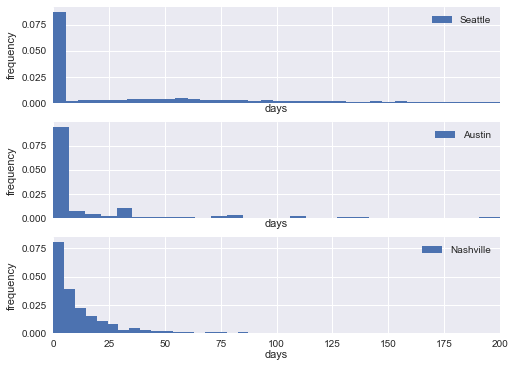

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize=(8,6))

ax1.hist(duration_seattle, bins = 600, normed = True)
ax2.hist(duration_austin, bins = 990, normed = True)
ax3.hist(duration_nashville, bins = 300, normed = True)

plt.xlim(0,200)

ax1.set_xlabel('days',labelpad=0.5)
ax2.set_xlabel('days',labelpad=0.5)
ax3.set_xlabel('days',labelpad=0.5)
ax1.set_ylabel('frequency')
ax2.set_ylabel('frequency')
ax3.set_ylabel('frequency')


ax1.legend(['Seattle'])
ax2.legend(['Austin'])
ax3.legend(['Nashville'])




(0, 600)

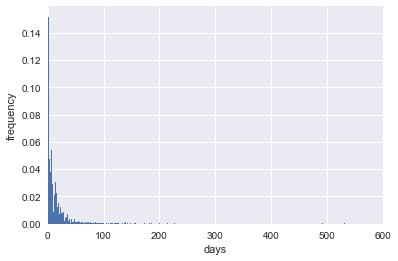

In [9]:
"""Histogram of the original dataset"""
plt.hist(duration, bins = 800, normed = True)
plt.xlabel('days')
plt.ylabel('frequency')
plt.xlim(0,600)

(0, 500)

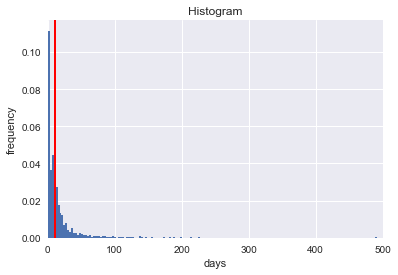

In [10]:
"""Modeling of Oringinal Dataset (currently use)"""
plt.hist(duration, bins = 500, normed = True)
plt.axvline(x=10, color='r', linewidth = 2)

plt.xlabel('days')
plt.ylabel('frequency')
plt.title('Histogram')
plt.xlim(0,500)


0.191940722696
47.5
0.0813032886724


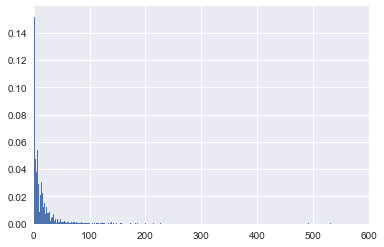

In [11]:
"""Refine dataset for modeling"""
plt.hist(duration, bins = 800, normed = True)
plt.xlim(0,600)
# Zero
zero = [x for x in duration if x == 0]
pz = float(len(zero))/len(duration)
print pz # %of 0s in dataset
nonzero = duration[duration != 0]
q1 = nonzero.quantile(q = 0.25) 
q3 = nonzero.quantile(q = 0.75)
stout = 1.5*(q3-q1) + q3 # Turkey's Fences for outlier in upper end
print stout 
out = [x for x in duration if x > 47.5] # not need to be exact same number cuz it's calculated by sampling data
po = float(len(out))/len(duration) # %of outliers in dataset
print(po)


(0, 200)

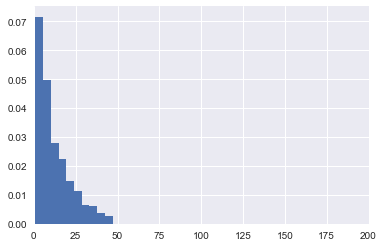

In [12]:
"""Histogram of the model dataset"""
dur = [x for x in duration if x > 0 and x < 47.5]
plt.hist(dur, bins = 10, normed = True)
plt.xlim(0,200)

11.8997206704 10.3555102289


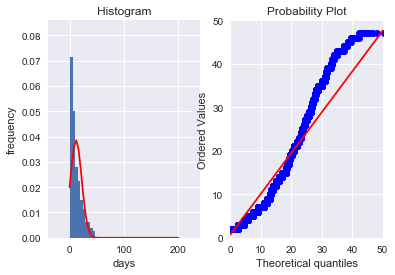

In [13]:
"""Modeling of Normal Distribution"""
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dur, bins = 10, normed = True)
lnspc = np.linspace(0, 200)
m,s = stats.norm.fit(dur)
pdf_g=stats.norm.pdf(lnspc,m,s)
print m,s
ax1.plot(lnspc,pdf_g, label="norm", color='r')
ax1.margins(0.2,0.2,tight=True)
ax1.set_xlabel('days')
ax1.set_ylabel('frequency')
ax1.set_title('Histogram')
#plt.xlim(0,200)
#plt.ylim(0,200)
stats.probplot(dur, dist="norm",sparams=(m,s),plot=ax2)
ax2.set_xlim(0,50)
ax2.set_ylim(0,50)
ax2.margins(0.2,0.2,tight=True)

0.73408863157 1.0 7.97564536656


(0, 50)

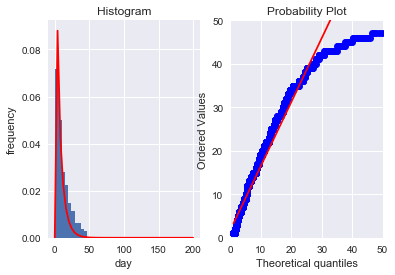

In [14]:
"""Modeling of Gamma Distribution"""
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dur, bins = 10, normed = True)
lnspc = np.linspace(0, 200)
a,l,b = stats.gamma.fit(dur)
print a, l, b
pdf_g=stats.gamma.pdf(lnspc,a,loc = l, scale = b)

ax1.plot(lnspc,pdf_g, label="gamma", color='r')
ax1.set_xlabel('day')
ax1.set_ylabel('frequency')
ax1.set_title('Histogram')
#plt.xlim(0,200)
#plt.ylim(0,200)
stats.probplot(dur, dist="gamma",sparams=(a, l ,b),plot=ax2)
ax2.set_xlim(0,50)
ax2.set_ylim(0,50)

/Users/rongdilin/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


0.900023307975 4.12174821178 1.0 49.1038017854


(0, 50)

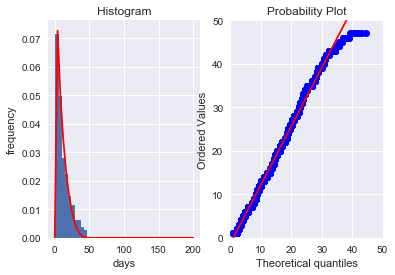

In [15]:
"""Modeling of Beta Distribution"""
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dur, bins = 10, normed = True)
lnspc = np.linspace(0, 200)
a,b,l,s = stats.beta.fit(dur)
print a, b, l, s
pdf_g=stats.beta.pdf(lnspc,a,b,l,s)

ax1.plot(lnspc,pdf_g, label="beta", color='r')
ax1.set_xlabel('day')
ax1.set_ylabel('frequency')
ax1.set_xlabel('days')
ax1.set_ylabel('frequency')
ax1.set_title('Histogram')
#plt.xlim(0,200)
#plt.ylim(0,200)
stats.probplot(dur, dist="beta",sparams=(a,b,l,s),plot=ax2)
ax2.set_xlim(0,50)
ax2.set_ylim(0,50)


2.82016334755 -12.6066921154 59.8117271287


/Users/rongdilin/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2303: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(0, 230)

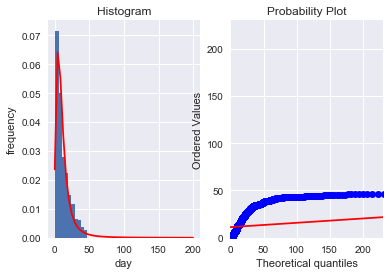

In [16]:
"""Modeling of Alpha Distribution"""
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dur, bins = 10, normed = True)
lnspc = np.linspace(0, 200)
a,l,scale = stats.alpha.fit(dur)
print a,l, scale
pdf_g=stats.alpha.pdf(lnspc,a,l,scale)

ax1.plot(lnspc,pdf_g, label="Alpha", color='r')
ax1.set_xlabel('day')
ax1.set_ylabel('frequency')

ax1.set_title('Histogram')
#plt.xlim(0,200)
#plt.ylim(0,200)
stats.probplot(dur, dist="alpha",sparams=(a,l,scale),plot=ax2) # deep dive to see red line -- e.g. param: line
ax2.set_xlim(0,230)
ax2.set_ylim(0,230)

In [ ]:
"""Modeling of Fisk Distribution"""
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(dur, bins = 10, normed = True)
lnspc = np.linspace(0, 200)
c,l,scale = stats.fisk.fit(dur)
print c,l, scale
pdf_g=stats.fisk.pdf(lnspc,c,l,scale)

ax1.plot(lnspc,pdf_g, label="Fisk", color='r')

ax1.set_xlabel('day')
ax1.set_ylabel('frequency')

ax1.set_title('Histogram')
#plt.xlim(0,200)
#plt.ylim(0,200)
stats.probplot(dur, dist="fisk",sparams=(c,l,scale),plot=ax2)
ax2.set_xlim(0,300)
ax2.set_ylim(0,300)

In [ ]:
owners_df = pd.read_excel('./DESaster-master/inputs/desaster_input_data_template.xlsx')
owners_df.columns


In [ ]:
env = simpy.Environment()

In [ ]:
write_story = True

In [ ]:
import random
def myfunc():
    prob = random.uniform(0,1)
    print prob
    if prob < 0.38:
        return norm(0,0)
    else:
        return gamma(0.883, 1.0, 49) # input params of the fitted model

In [ ]:
import random
def myfunc():
    prob = random.uniform(0,1)
    print prob
    if prob < 0.38:
        return norm(0,0)
    else:
        return beta(0.78, 1.99) # input params of the fitted model

In [ ]:
myfunc().rvs()

In [ ]:
fema_ia_dist = norm(loc = 10, scale = 0)
sba_home_sba_dist = norm(loc = 10, scale = 0)
sba_biz_sba_dist = norm(loc = 10, scale = 0)
insurance_dist = norm(loc = 10, scale = 0)
start_delay_dist = norm(loc = 10, scale = 0)
inspection_dist = norm(loc = 0.5, scale = 0)
assessment_dist = norm(loc = 10, scale = 0)
permitting_dist = myfunc() # remember to delete the .rvs() in the ProgramPermit self.duration.rvs()
print(permitting_dist)
repair_dist = norm(loc = 10, scale = 0)
demolition_dist = norm(loc = 10, scale = 0)
occupy_dist = norm(loc = 10, scale = 0)
find_home_dist = norm(loc = 10, scale = 0)

declaration = norm.rvs(loc = 30, scale = 0) # Placeholder deterministic scalar that defines number of days before federal disaster declared
sba_deadline = norm.rvs(loc = 60, scale = 0) # Typically duration in days after declaration that SBA applications must be submitted

In [ ]:
# Instantiate a FEMA Individual Assistance program
fema_ia = HousingAssistanceFEMA(env, staff=100, budget=10000000, duration=fema_ia_dist, 
                                max_outlay=30000, deadline=540, declaration=declaration)

# Instantiate a SBA Loan program to use w/ OwnerHouseholds
sba_home_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_home_sba_dist, 
                                max_loan = 200000, min_credit = 600, deadline=sba_deadline,
                                declaration=declaration)

# Instantiate a SBA Loan program to use w/ Landlords (higher maximum for businesses)
sba_biz_loan = RealPropertyLoanSBA(env, officers=10, inspectors=10, duration=sba_biz_sba_dist, 
                           max_loan = 2000000, deadline=sba_deadline, declaration=declaration) # SBA max biz loan = $2mil

# Instantiate a private insurance program
insurance = OwnersInsurance(env, staff=100, deductible=0.0, duration=insurance_dist)

# Instantiate a rapid inspeaction (tagging) program
inspection = InspectionProgram(env, staff=1000, duration=inspection_dist)

# Instantiate a detailed engineering assessment program
assessment = EngineeringAssessment(env, staff=1000, duration=assessment_dist)

# Instantiate a building permit processing program
permitting = PermitProgram(env, staff=1000, duration=permitting_dist) 

# Instantiate a program to represent private repair contractors
repair = RepairProgram(env, staff=1000, materials=1000000000, duration=repair_dist)

# Instantiate a program to represent private demolition contractors
demolition = DemolitionProgram(env, staff=1000, duration=demolition_dist)

In [ ]:
# Apply for insurance, FEMA IA, and SBA in that seqence
insurance_ia_sba_seq = Insurance_IA_SBA_Sequential(env)

# Apply for insurance, FEMA IA, and SBA in at the same time
insurance_ia_sba_para = Insurance_IA_SBA_Parallel(env)

# Apply for insurance first, then apply to FEMA IA and SBA at the same time
insurance_firstthen_ia_sba_para = Insurance_FirstThen_IA_SBA_Parallel(env)

# Apply for insurance and SBA in that seqence
insurance_sba_seq = Insurance_SBA_Sequential(env)

# Apply for insurance and SBA at the same time
insurance_sba_para = Insurance_SBA_Parallel(env)

# A policy to simulate government buyout to repair homes 
repair_stock = RepairVacantBuilding(env)

In [ ]:
owned_stock = FilterStore(env)  # To put the residences associated with owners

forsale_stock = FilterStore(env) # To put the homes associated with vacant home sellers
forrent_stock = FilterStore(env) # To put the homes associated with vacant home landlords

In [ ]:
# owners_df = nashville_clean

owners = importEntities(env, owners_df, 'OwnerHousehold', owned_stock, write_story)

In [ ]:
def basic_process(inspection_program, assessment_program, permit_program, repair_program, entity):
        
    yield env.process(inspection_program.process(entity.property, entity))
    
    yield env.process(assessment_program.process(entity.property, entity))
    
    yield env.process(permit_program.process(entity.property, entity))
    
    yield env.process(repair_program.process(entity.property, entity))

In [ ]:
def owner_process(env, inspection_program, insurance_program, fema_program, loan_program, 
                 assessment_program, permit_program, demolish_program, rebuild_program, 
                  search_stock, entity):
    
    money_patience = 200000  # days until give up the search for rebuild money
    home_patience = 15000  # days until give up the search for a new home
    
    # Do inspections after inspectors are mobilized
    yield env.timeout(start_delay_dist.rvs())
    yield env.process(inspection_program.process(entity.property, entity))
    
    # Process damaged properties
    if entity.property.damage_state == 'None':
        yield env.process(entity.occupy(duration = occupy_dist)) # For book keeping; ~unrealistic 
    else:
        
        # Homeowner search for financial assistance. Note two alternate versions 
        # can be used: insurance_ia_sba_para, insurance_ia_sba_seq, and insurance_firstthen_ia_sba_para. 
        # Paste in the desired policy approach below.
        yield env.process(insurance_firstthen_ia_sba_para.policy(insurance_program, fema_program,
                                                   loan_program, entity, money_patience))

        # If not enough money to repair home or home completely damaged, search for a new home 
        # to purchase.
        if (entity.recovery_funds.level < entity.property.damage_value or
                entity.property.damage_state == 'Complete'):

            yield env.process(entity.find_home(search_stock, find_home_dist, down_payment_pct = 0.10,
                                                  search_patience = home_patience))
            
            if entity.gave_up_home_search == None:
                yield env.process(entity.occupy(duration = occupy_dist))
            
            return
        # Otherwise repair home.       
        elif entity.recovery_funds.level >= entity.property.damage_value:
            
            yield env.process(assessment_program.process(entity.property, entity))
            yield env.process(permit_program.process(entity.property, entity))
            if entity.property.damage_state == 'Extensive' or entity.property.damage_state == 'Complete':
                yield env.process(demolish_program.process(entity.property, entity))
            yield env.process(rebuild_program.process(entity.property, entity))    
            yield env.process(entity.occupy(duration = occupy_dist))

In [ ]:
#inspect.getfullargspec(owner_process).args # Useful to determine what arguments are required for the process.

for i in range(len(owners)):
    env.process(owner_process(env, inspection, insurance, fema_ia, sba_home_loan, 
                                    assessment, permitting, demolition, repair,
                                    owned_stock, owners[i]))

In [ ]:
env.run()

In [ ]:
output_summary(owners, 'OwnerHousehold')

In [ ]:
owners[0].story


In [ ]:
df = households_to_df(owners)

In [ ]:
df.columns

In [ ]:
event_list=[]

for i in df.columns:
    if "get" in i or "put" in i or "stop" in i or "start" in i or "name" in i or "gave" in i:
        event_list.append(i)

event_df = df[event_list]
event_df = event_df.set_index('name')

In [ ]:
event_df

In [ ]:
names = sorted([f for f in df['name']])

name_chooser = Dropdown(
    options=names
)
display(name_chooser)

In [ ]:
name = name_chooser.value

name_row = df[df['name']==name][['inspection_put',
 'inspection_get',
 'fema_put',
 'fema_get',
 'assessment_put',
 'assessment_get',
 'permit_put',
 'permit_get',
'occupy_put',
'occupy_get',
 'home_put',
 'home_get']]

%matplotlib inline
plt.figure(figsize=(10,10))
sns.set_style(style="whitegrid")
sns.set(font_scale=2)
ax = sns.stripplot(name_row.iloc[0], name_row.columns, jitter=True, size = 15, linewidth=1)
ax.set(xlabel="Days After Event", ylabel="Housing Recovery Events for {0}".format(name))